# Sentiment Analysis on Amazon data 

Introduction:
    One of the leading online ecommerce websites is Amazon, So, we are working on the datasets of 2016-2018 on electronic products and 2022 products to understand the review analysis of amazon products and understand the amazon data.
    

## Initializing Spark

In [1]:
import findspark
findspark.init() 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
!pip install missingno

In [4]:
# Library used for Sentiment Analysis
!pip install vaderSentiment

In [5]:
import os
import sys
#set the path

import pyspark
import re
import string
import pandas

from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#import scikitplot as skplt
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import HiveContext
from pyspark.sql.functions import *
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize   

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext

from pyspark import HiveContext

from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel,LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from vaderSentiment import vaderSentiment
from pyspark.ml.feature import NGram
import matplotlib
matplotlib.style.use('ggplot')
import plotly.express as px

### Spark Congiguration to access data from 2022 products of Amazon from Mongo db
Initially the file had 28 MB of data is uploaded into the Mongodb and the bson format data is loaded.

In [6]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

working_directory = 'jars/*'

my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri=mongodb://127.0.0.1/AmazonReviews.Products") \
    .config("spark.mongodb.output.uri=mongodb://127.0.0.1/AmazonReviews.Products") \
    .config('spark.driver.extraClassPath', working_directory) \
    .getOrCreate()

Reading data from MongoDB:

Database: AmazonReviews

Collection: Products

In [7]:
# Reading data from database - MongoDB
df = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").option("Database", "AmazonReviews").option("Collection", "Products").load()

In [8]:
#dataframe 20 rows using show()
df.show()

+--------------------+--------------------------------+---------------------+------------------------------+--------------------+-------------------------------------------+------------+-------------------------+----------------------------+-----------------+-------+--------------------+--------------------+--------------------+--------------------+
|                 _id|amazon_category_and_sub_category|average_review_rating|customer_questions_and_answers|         description|items_customers_buy_after_viewing_this_item|manufacturer|number_available_in_stock|number_of_answered_questions|number_of_reviews|  price| product_description| product_information|        product_name|             uniq_id|
+--------------------+--------------------------------+---------------------+------------------------------+--------------------+-------------------------------------------+------------+-------------------------+----------------------------+-----------------+-------+--------------------+--------

In [9]:
# columns of the dataframe
df.columns

['_id',
 'amazon_category_and_sub_category',
 'average_review_rating',
 'customer_questions_and_answers',
 'description',
 'items_customers_buy_after_viewing_this_item',
 'manufacturer',
 'number_available_in_stock',
 'number_of_answered_questions',
 'number_of_reviews',
 'price',
 'product_description',
 'product_information',
 'product_name',
 'uniq_id']

## Data Cleaning

In [10]:
# Finding missing values in the dataframe
from pyspark.sql.functions import isnan, when, count, col
missing = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns[3:]])
missing.head()

Row(customer_questions_and_answers=9089, description=652, items_customers_buy_after_viewing_this_item=3068, manufacturer=8, number_available_in_stock=2502, number_of_answered_questions=767, number_of_reviews=20, price=1437, product_description=653, product_information=61, product_name=2, uniq_id=2)

In [11]:
missing.show()

+------------------------------+-----------+-------------------------------------------+------------+-------------------------+----------------------------+-----------------+-----+-------------------+-------------------+------------+-------+
|customer_questions_and_answers|description|items_customers_buy_after_viewing_this_item|manufacturer|number_available_in_stock|number_of_answered_questions|number_of_reviews|price|product_description|product_information|product_name|uniq_id|
+------------------------------+-----------+-------------------------------------------+------------+-------------------------+----------------------------+-----------------+-----+-------------------+-------------------+------------+-------+
|                          9089|        652|                                       3068|           8|                     2502|                         767|               20| 1437|                653|                 61|           2|      2|
+------------------------------+

<AxesSubplot:>

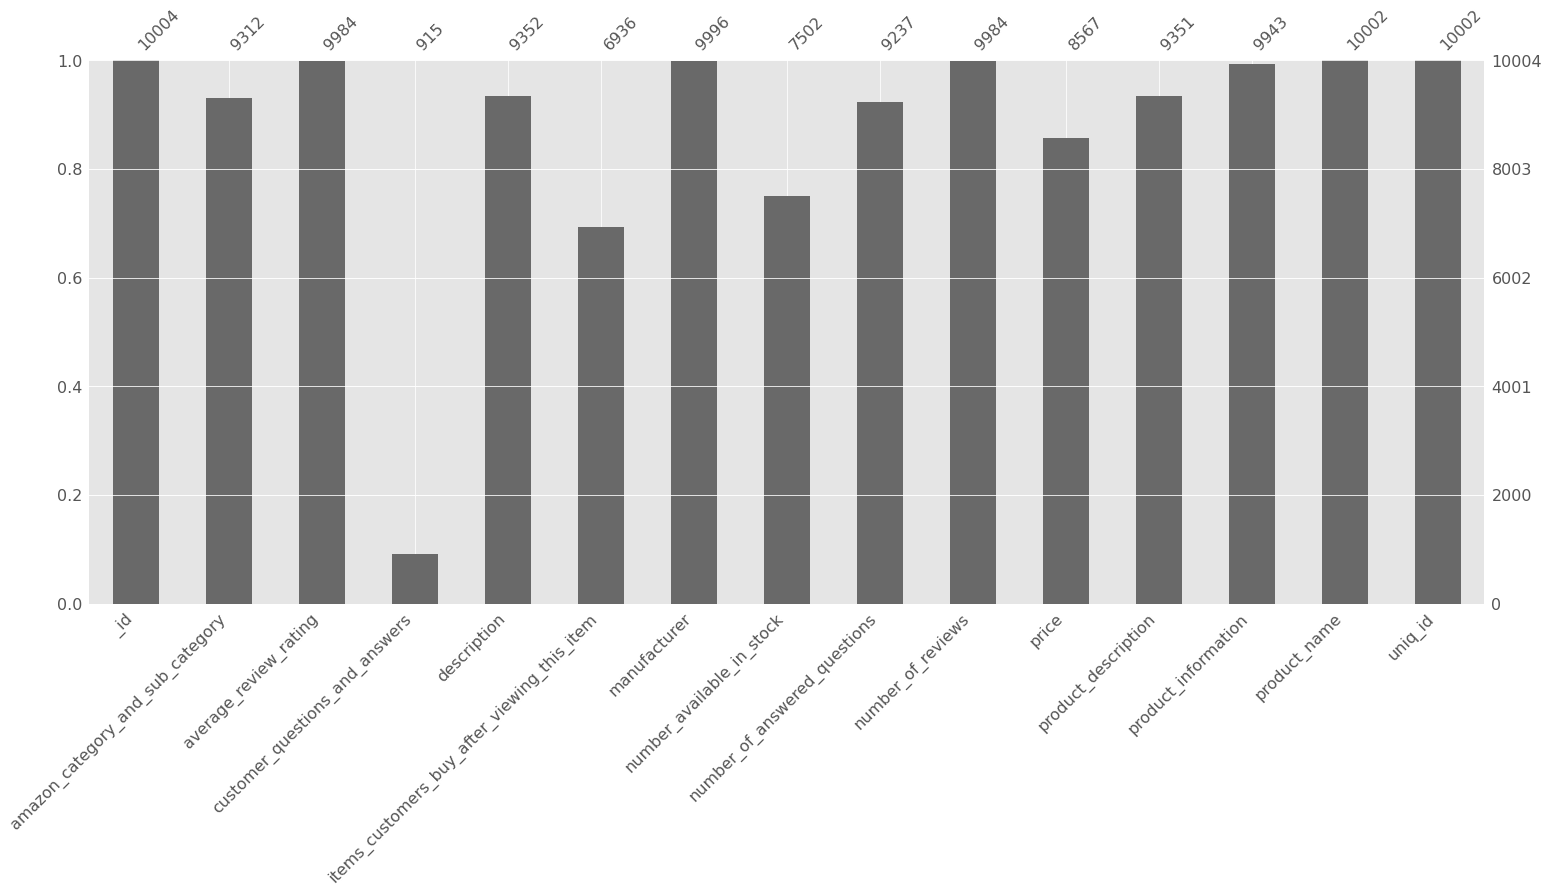

In [12]:
# Represntation of missing values
import missingno as msno
msno.bar(df.toPandas())

<AxesSubplot:>

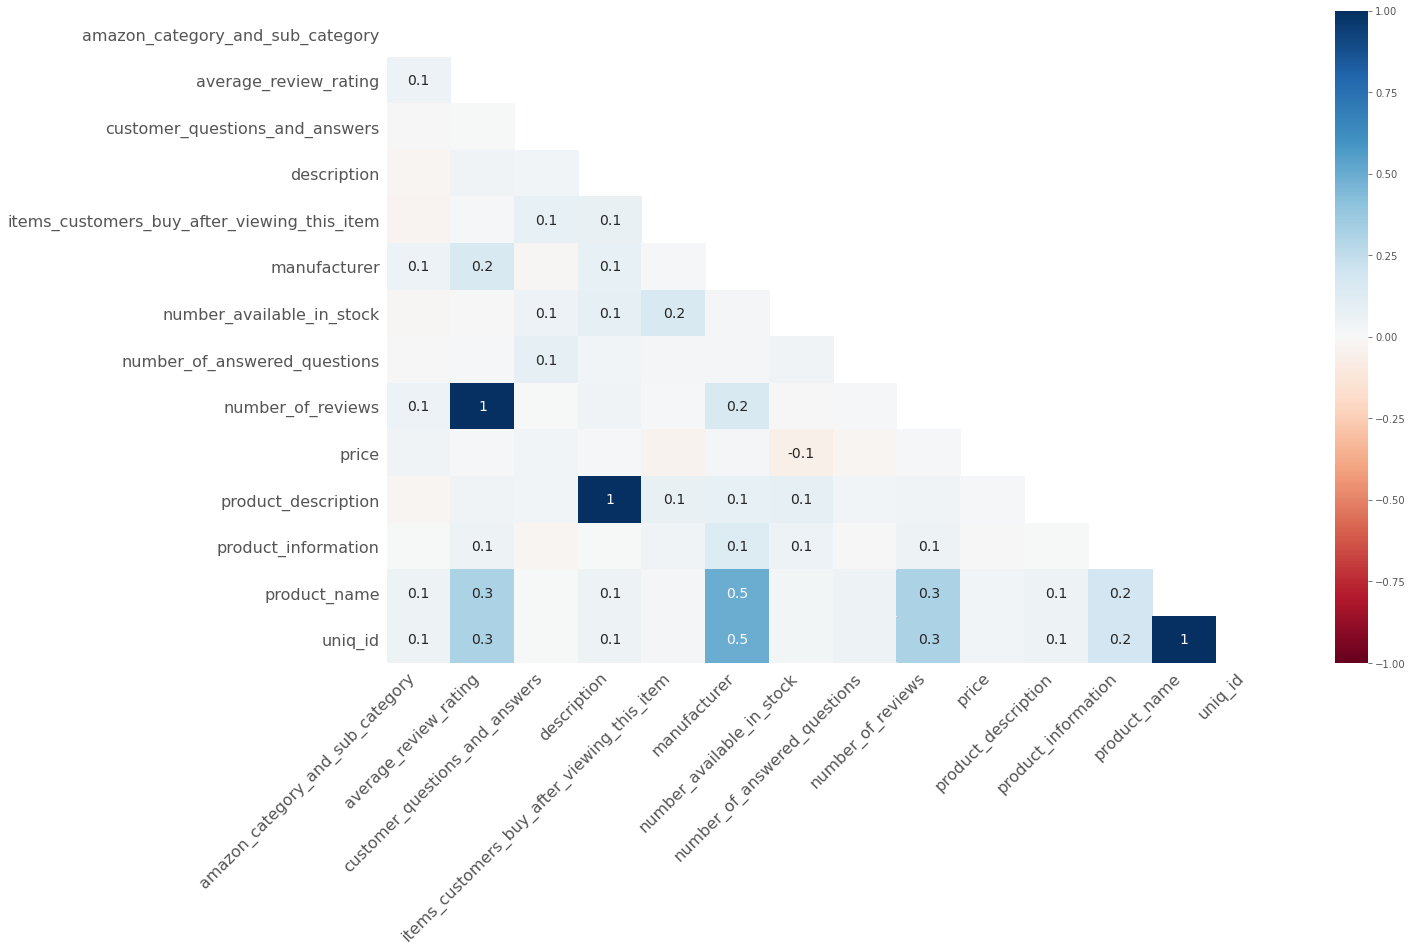

In [13]:
# Heatmap for missing values
msno.heatmap(df.toPandas())

Visualizing the data to understand insights from the data through Pandas library

In [14]:
df1 = df.toPandas()

In [15]:
df1.head()

,_id,amazon_category_and_sub_category,average_review_rating,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,price,product_description,product_information,product_name,uniq_id
0,"(627d424b66d833ad31566bfe,)",Hobbies > Model Trains & Railway Sets > Rail V...,4.9 out of 5 stars,Does this catalogue detail all the previous Ho...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Hornby,5 new,1,15,£3.42,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Hornby 2014 Catalogue,eac7efa5dbd3d667f26eb3d3ab504464
1,"(627d424b66d833ad31566bff,)",Hobbies > Model Trains & Railway Sets > Rail V...,4.5 out of 5 stars,can you turn off sounds // hi no you cant turn...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,FunkyBuys,None,1,2,£16.99,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,FunkyBuys® Large Christmas Holiday Express Fes...,b17540ef7e86e461d37f3ae58b7b72ac
2,"(627d424b66d833ad31566c00,)",Hobbies > Model Trains & Railway Sets > Rail V...,3.9 out of 5 stars,What is the gauge of the track // Hi Paul.Trut...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,ccf,2 new,2,17,£9.99,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,348f344247b0c1a935b1223072ef9d8a
3,"(627d424b66d833ad31566c01,)",Hobbies > Model Trains & Railway Sets > Rail V...,5.0 out of 5 stars,None,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,None,Hornby,None,2,1,£39.99,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,e12b92dbb8eaee78b22965d2a9bbbd9f
4,"(627d424b66d833ad31566c02,)",Hobbies > Model Trains & Railway Sets > Rail V...,4.7 out of 5 stars,None,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,Hornby,None,2,3,£32.19,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,e33a9adeed5f36840ccc227db4682a36


In [16]:
df1.shape[0]

10004

In [17]:
# Filling the values of number_of_reviews column as 0
import pandas as pd
df2 = pd.concat([df1[:2003],df1[2010:]])
df2['number_of_reviews'] = df2['number_of_reviews'].fillna('0')
df2['number_of_reviews'].unique()

array(['15', '2', '17', '1', '3', '36', '8', '21', '4', '5', '19', '53',
       '6', '38', '10', '7', '0', '9', '13', '18', '97', '28', '12', '67',
       '81', '23', '41', '11', '16', '45', '42', '32', '27', '40', '31',
       '35', '29', '120', '33', '26', '24', '85', '25', '43', '138', '82',
       '46', '14', '72', '22', '106', '76', '420', '160', '39', '30',
       '199', '129', '56', '291', '87', '86', '20', '34', '142', '92',
       '55', '64', '77', '243', '130', '68', '253', '101', '102', '122',
       '73', '118', '145', '381', '802', '299', '59', '518', '158', '44',
       '98', '58', '47', '600', '57', '50', '78', '94', '51', '37', '210',
       '165', '103', '185', '116', '149', '168', '71', '649', '265',
       '355', '79', '100', '83', '61', '48', '70', '65', '49', '54', '66',
       '60', '238', '133', '88', '110', '117', '109', '127', '63', '111',
       '141', '99', '204', '124', '95', '220', '137', '90', '172', '134',
       '115', '80', '91', '125', '119', '131', '1

In [18]:
# Considering the threshold value as 70% and dropping the columns
missing_perc = 70.0 
min_count =  int(((100 - missing_perc)/100) * df1.shape[1] + 1)
df_new = df2.dropna(axis = 1, thresh = min_count)

Maping amazon categories and subcategories.

In [19]:
import numpy as np
import pandas as pd
def mapcategories(srs):
    if pd.isnull(srs):
        return []
    else:
        return [cat.strip() for cat in srs.split(">")]
    
category_lists = df2['amazon_category_and_sub_category'].apply(mapcategories)
category_lists.map(lambda lst: len(lst)).value_counts()

3    3986
2    3923
4    1312
0     691
5      85
Name: amazon_category_and_sub_category, dtype: int64

## Exploratory Data Analysis

From average review rating, visualizing the reviews average for the questions asked

In [20]:
# Grouping data to know the number of questions posed on the rating
from pyspark.sql.functions import length
df.withColumn('customer_questions_and_answers', length('customer_questions_and_answers')).groupBy('average_review_rating').avg('customer_questions_and_answers').show()

+---------------------+-----------------------------------+
|average_review_rating|avg(customer_questions_and_answers)|
+---------------------+-----------------------------------+
|   3.5 out of 5 stars|                              156.5|
| {""text"":""Amazo...|                               27.0|
|                 null|                              121.0|
|   4.2 out of 5 stars|                  490.8333333333333|
|   3.7 out of 5 stars|                               null|
|   4.1 out of 5 stars|                  482.3333333333333|
|   3.9 out of 5 stars|                              400.0|
|   4.9 out of 5 stars|                  317.7413793103448|
|   2.3 out of 5 stars|                               null|
|   3.8 out of 5 stars|                               null|
|   3.3 out of 5 stars|                              413.0|
|   4.0 out of 5 stars|                  301.3970588235294|
|   3.6 out of 5 stars|                               null|
|   4.5 out of 5 stars|                 

Directed graphs are used to inderstand the categorical data and assigning nodes to it.

In [21]:
# Finding number of links possible with first edge using the direct graph
import networkx as nx
DG = nx.DiGraph()

category_lists.map(lambda cats: DG.add_nodes_from(cats))
category_lists.map(lambda cats: [DG.add_edge(cats[i], cats[i + 1]) for i in range(len(cats) - 1)])

print("The number of categorical links possible is {0}.".format(len(DG.edges())))

The number of categorical links possible is 324.


In [22]:
# Finding the leaf nodes and root nodes of the categories
t_cat = category_lists[category_lists.map(lambda c: len(c) > 0)].map(lambda l: l[0])
b_cat = category_lists[category_lists.map(lambda c: len(c) > 0)].map(lambda l: l[-1])

print("There are {0} top root categories.".format(len(set(t_cat))))
print("There are {0} bottom leaf categories.".format(len(set(b_cat))))

products = df2.assign(root_category=t_cat.astype('category'), 
                           l_category=b_cat.astype('category'))

There are 43 top root categories.
There are 235 bottom leaf categories.


converting the numeric values of 'number_of_reviews' which is in string

In [23]:

products['number_of_reviews'] = products['number_of_reviews'].str.replace(",", "")
products['number_of_reviews'] = pd.to_numeric(products['number_of_reviews'])
def curr_value(v):
    if pd.isnull(v):
        return 0
    try:
        return float(v[1:])
    except ValueError:
        return 0
    
products['price'] = products['price'].map(curr_value)

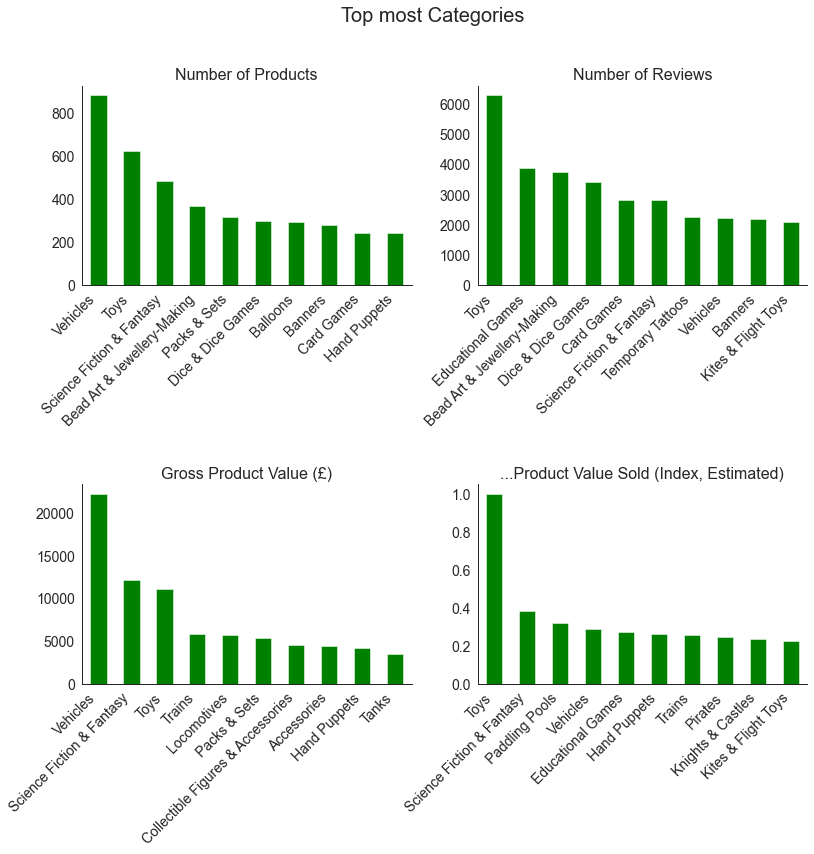

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

fig, arrax = plt.subplots(2, 2)
fig.subplots_adjust(hspace=1)
plt.suptitle('Top most Categories', fontsize= 20)

bar_kwargs = {'figsize': (13, 11), 'fontsize': 14, 'color': 'green'}

products['l_category'].value_counts().head(10).plot.bar(
    title='Number of Products', ax=arrax[0][0], **bar_kwargs
)
(products.groupby('l_category')
     ['number_of_reviews']
     .sum()
     .sort_values(ascending=False)
     .rename_axis(None)
     .head(10)
     .plot.bar(
        title='Number of Reviews', ax=arrax[0][1], **bar_kwargs
     ))
(products.groupby('l_category')
     ['price']
     .sum()
     .sort_values(ascending=False)
     .rename_axis(None)
     .head(10)
     .plot.bar(
        title='Gross Product Value (£)', ax=arrax[1][0], **bar_kwargs
     ))
(products
     .assign(
         pval=products.apply(lambda p: p['price'] * p['number_of_reviews'], axis='columns')
     )
     .groupby('l_category')
     .sum()
     .pipe(lambda df: df.assign(pval=df['pval'] / df['pval'].max()))
     .pval
     .sort_values(ascending=False)
     .rename_axis(None)
     .head(10)
     .plot.bar(
         title='...Product Value Sold (Index, Estimated)', 
         ax=arrax[1][1], **bar_kwargs
     )
)
sns.despine()

for (a, b) in [(0, 0), (0, 1), (1,0), (1,1)]:
    arrax[a][b].title.set_fontsize(16)
    arrax[a][b].set_xticklabels(arrax[a][b].get_xticklabels(), 
                                rotation=45, ha='right', fontsize=14)

## Comments:
Among the data, Vehicles products are sold more, in which Toys had more reviews, the gross product value is found to be high for the vehicles. 

Plotting for the top manufacturers.

In [25]:
# Categorizing new and used items in the data frame
item = ["new", "used"]
df_new["item_type"] = df2['number_available_in_stock'].str.extract(f'({"|".join(item)})')
df_new

,_id,amazon_category_and_sub_category,average_review_rating,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,price,product_description,product_information,product_name,uniq_id,item_type
0,"(627d424b66d833ad31566bfe,)",Hobbies > Model Trains & Railway Sets > Rail V...,4.9 out of 5 stars,Does this catalogue detail all the previous Ho...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Hornby,5 new,1,15,£3.42,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Hornby 2014 Catalogue,eac7efa5dbd3d667f26eb3d3ab504464,new
1,"(627d424b66d833ad31566bff,)",Hobbies > Model Trains & Railway Sets > Rail V...,4.5 out of 5 stars,can you turn off sounds // hi no you cant turn...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,FunkyBuys,None,1,2,£16.99,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,FunkyBuys® Large Christmas Holiday Express Fes...,b17540ef7e86e461d37f3ae58b7b72ac,NaN
2,"(627d424b66d833ad31566c00,)",Hobbies > Model Trains & Railway Sets > Rail V...,3.9 out of 5 stars,What is the gauge of the track // Hi Paul.Trut...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,ccf,2 new,2,17,£9.99,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,348f344247b0c1a935b1223072ef9d8a,new
3,"(627d424b66d833ad31566c01,)",Hobbies > Model Trains & Railway Sets > Rail V...,5.0 out of 5 stars,None,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,None,Hornby,None,2,1,£39.99,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,e12b92dbb8eaee78b22965d2a9bbbd9f,NaN
4,"(627d424b66d833ad31566c02,)",Hobbies > Model Trains & Railway Sets > Rail V...,4.7 out of 5 stars,None,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,Hornby,None,2,3,£32.19,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,e33a9adeed5f36840ccc227db4682a36,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,"(627d424d66d833ad3156930d,)",Hobbies > Collectible Figures & Memorabilia > ...,5.0 out of 5 stars,None,DC 66 Batman Classic TV Series 6 Inch Riddler ...,None,Mattel,5 new,3,3,£22.95,DC 66 Batman Classic TV Series 6 Inch Riddler ...,Technical Details Item Weight136 g Product Dim...,Batman 1966 TV Series Action Figures - The Rid...,44d6967f083825a5de36ad4865a65bcd,new
10000,"(627d424d66d833ad3156930e,)",Characters & Brands > Star Wars > Toys,4.0 out of 5 stars,None,None,http://www.amazon.co.uk/Storm-Trooper-Costume-...,Star Wars,None,3,1,£39.99,None,Technical Details Additional Information AS...,"Star Wars Costume, Kids Stormtrooper Costume S...",08f0747b6fc6687215ffb994c3a6fb32,NaN
10001,"(627d424d66d833ad3156930f,)",Novelty & Special Use > Novelty > Accessories ...,5.0 out of 5 stars,None,*Includes 1x Badge with holder and chain *High...,http://www.amazon.co.uk/Olde-Scotland-Yard-Ltd...,Olde Scotland Yard Ltd.,3 new,3,1,£43.99,*Includes 1x Badge with holder and chain *High...,Technical Details Item Weight159 g Product Dim...,Defiance Lawkeeper Metal Badge Prop Replica,bf6cc073f8f24e6e338190fa16f6ee9d,new
10002,"(627d424d66d833ad31569310,)",Hobbies > Collectible Figures & Memorabilia > ...,5.0 out of 5 stars,None,Designed by Ed BenesIt's here - the third seri...,None,DC Comics,3 new,3,1,£49.81,Designed by Ed BenesIt's here - the third seri...,Technical Details Item Weight181 g Product Dim...,Justice League of America Series 3 Green Lante...,cd783d0b8b4

Removing currency symbol

In [26]:
# removing currency label from price column
df_new["price_new"] = df_new["price"].str.split(" ", expand = True).get(0).str.split("£", expand = True).get(1)

In [27]:
df_new[df_new.price_new.str.contains(',', na=False)]
# remove the comma sign
df_new["price_new"] = df_new["price_new"].str.replace(",", "")

In [28]:
df_new["number_available_in_stock"] = df_new["number_available_in_stock"].str.extract("(\d+)").astype(np.float)

# keep only number in the column
df_new["average_review_rating(out of 5)"] = df_new["average_review_rating"].str.split(" out of ", expand = True).get(0)

In [29]:
# Splittig the dataframe based on category
split_df = df_new["amazon_category_and_sub_category"].str.split(">", expand = True)
df_new["root_category"] = split_df.get(0)
df_new["leaf_category_1"] = split_df.get(1)
df_new["leaf_category_2"] = split_df.get(2)
df_new["leaf_category_3"] = split_df.get(3)

In [30]:
#Unique item_type in the df_new dataframe
df_new["item_type"].unique()

array(['new', nan, 'used'], dtype=object)

In [31]:
#Unique ratings 
products.average_review_rating.unique()

array(['4.9 out of 5 stars', '4.5 out of 5 stars', '3.9 out of 5 stars',
       '5.0 out of 5 stars', '4.7 out of 5 stars', '4.3 out of 5 stars',
       '4.8 out of 5 stars', '4.0 out of 5 stars', '4.2 out of 5 stars',
       '4.6 out of 5 stars', '4.1 out of 5 stars', None,
       '4.4 out of 5 stars', '3.5 out of 5 stars', '3.0 out of 5 stars',
       '3.3 out of 5 stars', '3.7 out of 5 stars', '3.8 out of 5 stars',
       '3.6 out of 5 stars', '2.3 out of 5 stars'], dtype=object)

In [32]:
df_new["price_new"] = df_new["price"].str.split(" ", expand = True).get(0).str.split("£", expand = True).get(1)
# checking if the va;ue is in the ramge of 1000
df_new[df_new.price_new.str.contains(',', na=False)]


,_id,amazon_category_and_sub_category,average_review_rating,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,...,product_information,product_name,uniq_id,item_type,price_new,average_review_rating(out of 5),root_category,leaf_category_1,leaf_category_2,leaf_category_3
7098,"(627d424c66d833ad315687b8,)",Hobbies > Model Trains & Railway Sets > Access...,4.0 out of 5 stars,None,Sideshow Collectibles is proud to present the ...,None,Bowen Designs,2.0,1,1,...,Technical Details Item Weight6 Kg Product Dime...,Bowen Designs - Marvel Statue Thor Classic Act...,75d96583894e50412ba5c0161375fef5,new,"2,439.92",4.0,Hobbies,Model Trains & Railway Sets,Accessories,Figures & Decoration Parts


In [33]:
# removing comma sign
df_new["price_new"] = df_new["price_new"].str.replace(",", "")

In [34]:
df_new["average_review_rating(out of 5)"] = df_new["average_review_rating(out of 5)"].astype(float)
df_new["price_new"] = df_new["price_new"].astype(float)

In [35]:
pd.to_numeric(df_new["number_of_reviews"], errors='coerce')
pd.to_numeric(df_new["number_of_reviews"], errors='coerce').isnull()
df_new[pd.to_numeric(df_new["number_of_reviews"], errors='coerce').isnull()]


,_id,amazon_category_and_sub_category,average_review_rating,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,...,product_information,product_name,uniq_id,item_type,price_new,average_review_rating(out of 5),root_category,leaf_category_1,leaf_category_2,leaf_category_3
8876,"(627d424c66d833ad31568eaa,)",Characters & Brands > Tomy,4.5 out of 5 stars,Is this good for 5 and 6 year old kids? // Hi ...,Style Name:Pop-Up-Pirate/T7028 Product Descrip...,None,Tomy,59.0,11,"1,040",...,Technical Details Brand Tomy Model NumberT7028...,TOMY Pop-Up Pirate,c751a76dd7668f78b4222b5547e7249b,new,9.99,4.5,Characters & Brands,Tomy,None,None
9319,"(627d424d66d833ad31569065,)",Games > Educational Games,4.7 out of 5 stars,None,Colour Name:No Manufacturer's Description Bana...,http://www.amazon.co.uk/Eco-Premium-Life%C2%AE...,Winning Moves,42.0,1,"1,399",...,Technical Details Item Weight381 g Product Dim...,Bananagrams Game,c30905e0fd0f5af84be16f794180559d,new,9.98,4.7,Games,Educational Games,None,None


In [36]:
# removing comma sign
df_new["number_of_reviews"] = df_new["number_of_reviews"].str.replace(",", "")

# changing the type of column
df_new["number_of_reviews"] = df_new["number_of_reviews"].astype(float)

In [37]:
#converting the type to float
df_new["number_of_answered_questions"] = df_new["number_of_answered_questions"].astype(float)

In [38]:
df_new.drop(["price", "average_review_rating", 
             "amazon_category_and_sub_category"],  axis=1, inplace = True)

In [39]:
df_new.head()

,_id,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,product_description,product_information,product_name,uniq_id,item_type,price_new,average_review_rating(out of 5),root_category,leaf_category_1,leaf_category_2,leaf_category_3
0,"(627d424b66d833ad31566bfe,)",Does this catalogue detail all the previous Ho...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Hornby,5.0,1.0,15.0,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Hornby 2014 Catalogue,eac7efa5dbd3d667f26eb3d3ab504464,new,3.42,4.9,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
1,"(627d424b66d833ad31566bff,)",can you turn off sounds // hi no you cant turn...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,FunkyBuys,NaN,1.0,2.0,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,FunkyBuys® Large Christmas Holiday Express Fes...,b17540ef7e86e461d37f3ae58b7b72ac,NaN,16.99,4.5,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
2,"(627d424b66d833ad31566c00,)",What is the gauge of the track // Hi Paul.Trut...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,ccf,2.0,2.0,17.0,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,348f344247b0c1a935b1223072ef9d8a,new,9.99,3.9,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
3,"(627d424b66d833ad31566c01,)",None,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,None,Hornby,NaN,2.0,1.0,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,e12b92dbb8eaee78b22965d2a9bbbd9f,NaN,39.99,5.0,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
4,"(627d424b66d833ad31566c02,)",None,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,Hornby,NaN,2.0,3.0,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,e33a9adeed5f36840ccc227db4682a36,NaN,32.19,4.7,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains


In [40]:
# New dataframe with price as a subset
p_df = df_new.dropna(subset=['price_new'])
p_df.head()

,_id,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,product_description,product_information,product_name,uniq_id,item_type,price_new,average_review_rating(out of 5),root_category,leaf_category_1,leaf_category_2,leaf_category_3
0,"(627d424b66d833ad31566bfe,)",Does this catalogue detail all the previous Ho...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Hornby,5.0,1.0,15.0,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Hornby 2014 Catalogue,eac7efa5dbd3d667f26eb3d3ab504464,new,3.42,4.9,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
1,"(627d424b66d833ad31566bff,)",can you turn off sounds // hi no you cant turn...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,FunkyBuys,NaN,1.0,2.0,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,FunkyBuys® Large Christmas Holiday Express Fes...,b17540ef7e86e461d37f3ae58b7b72ac,NaN,16.99,4.5,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
2,"(627d424b66d833ad31566c00,)",What is the gauge of the track // Hi Paul.Trut...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,ccf,2.0,2.0,17.0,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,348f344247b0c1a935b1223072ef9d8a,new,9.99,3.9,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
3,"(627d424b66d833ad31566c01,)",None,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,None,Hornby,NaN,2.0,1.0,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,e12b92dbb8eaee78b22965d2a9bbbd9f,NaN,39.99,5.0,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains
4,"(627d424b66d833ad31566c02,)",None,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,Hornby,NaN,2.0,3.0,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,e33a9adeed5f36840ccc227db4682a36,NaN,32.19,4.7,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains


In [41]:
p_df[["price_new", "manufacturer"]].groupby("manufacturer").max().sort_values(by = "price_new",ascending = False)

,price_new
manufacturer,
Bowen Designs,2439.92
DJI,995.11
Sideshow,719.95
AUTOart,648.95
Bushiroad,629.95
...,...
k2-accessories Acrylic Plastic Beads,0.90
Card Concept,0.83
unisex party bag fillers,0.60


In [42]:
values = p_df["manufacturer"].value_counts().keys().tolist()[:10]
counts = p_df["manufacturer"].value_counts().tolist()[:10]

In [43]:
values

['Oxford Diecast',
 'LEGO',
 'Disney',
 'Playmobil',
 'The Puppet Company',
 'Star Wars',
 'MyTinyWorld',
 'Mattel',
 'Hasbro',
 'Corgi']

Top 10 manufacturers, in which 'Oxford Diecast' products are more sold

In [44]:
# dataframe for 10 top manufacturers
df_list = []
for i in values:
    x = p_df[p_df["manufacturer"] == i]
    df_list.append(x)
dframe = pd.concat(df_list)
dframe.head()

,_id,customer_questions_and_answers,description,items_customers_buy_after_viewing_this_item,manufacturer,number_available_in_stock,number_of_answered_questions,number_of_reviews,product_description,product_information,product_name,uniq_id,item_type,price_new,average_review_rating(out of 5),root_category,leaf_category_1,leaf_category_2,leaf_category_3
804,"(627d424b66d833ad31566f22,)",None,"The Ford Anglia , appeared in 1959 and when it...",http://www.amazon.co.uk/Cararama-Anglia-Sunbur...,Oxford Diecast,4.0,11.0,4.0,"The Ford Anglia , appeared in 1959 and when it...",Technical Details Item Weight18 g Product Dime...,Oxford Diecast Anglia Police Panda 76105003,d994e8cb4d0b15683da91652901d9895,new,4.75,4.8,Die-Cast & Toy Vehicles,Toy Vehicles & Accessories,Scaled Models,Vehicles
830,"(627d424b66d833ad31566f3c,)",None,Product Description In the early 1960s the mos...,http://www.amazon.co.uk/Omnibus-RM075-OMNIBUS-...,Oxford Diecast,5.0,1.0,1.0,Product Description In the early 1960s the mos...,Technical Details Item Weight82 g Product Dime...,Oxford Diecast Evening News Metal Model,8f4a9ace7bb4ae6e6d8dda96d94bd332,new,10.95,5.0,Die-Cast & Toy Vehicles,Toy Vehicles & Accessories,Scaled Models,Vehicles
835,"(627d424b66d833ad31566f41,)",None,Oxford has released a 1:43 diecast model of th...,None,Oxford Diecast,NaN,1.0,1.0,Oxford has released a 1:43 diecast model of th...,Technical Details Item Weight100 g Product Dim...,Jaguar SS 2.5 Saloon - Cream,af9511db607fe37119d4487c12f4d91d,NaN,24.99,5.0,Die-Cast & Toy Vehicles,Toy Vehicles & Accessories,Scaled Models,Vehicles
838,"(627d424b66d833ad31566f44,)",None,"Bertram Mills David Brown tractor, NLP 751 was...",None,Oxford Diecast,6.0,1.0,1.0,"Bertram Mills David Brown tractor, NLP 751 was...",Technical Details Item Weight23 g Product Dime...,Oxford Diecast Bertram Mills David Brown Tract...,168f748bc19af21dfabafdefb65522a0,new,7.21,5.0,Die-Cast & Toy Vehicles,Toy Vehicles & Accessories,Scaled Models,Vehicles
839,"(627d424b66d833ad31566f45,)",None,Rover chief engineer Maurice Wilks was inspire...,http://www.amazon.co.uk/Oxford-Diecast-76LAN18...,Oxford Diecast,7.0,1.0,2.0,Rover chief engineer Maurice Wilks was inspire...,Technical Details Item Weight14 g Product Dime...,Oxford Diecast Bronze Green 76LAN188003,231cc7273399cc91df8f5d452eea4283,new,6.75,4.5,Die-Cast & Toy Vehicles,Toy Vehicles & Accessories,Scaled Models,Vehicles


In [45]:
# categorizing the rating based on manufacturer
dframe[["manufacturer", "average_review_rating(out of 5)"]].groupby("manufacturer").mean().sort_values(by = "average_review_rating(out of 5)",ascending = False)

,average_review_rating(out of 5)
manufacturer,
MyTinyWorld,4.923656
Oxford Diecast,4.790789
Corgi,4.783333
The Puppet Company,4.759804
Star Wars,4.738710
LEGO,4.736232
Playmobil,4.726496
Disney,4.687500
Mattel,4.661039


In [46]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058 entries, 804 to 8997
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   _id                                          1058 non-null   object 
 1   customer_questions_and_answers               105 non-null    object 
 2   description                                  1022 non-null   object 
 3   items_customers_buy_after_viewing_this_item  738 non-null    object 
 4   manufacturer                                 1058 non-null   object 
 5   number_available_in_stock                    853 non-null    float64
 6   number_of_answered_questions                 962 non-null    float64
 7   number_of_reviews                            1058 non-null   float64
 8   product_description                          1022 non-null   object 
 9   product_information                          1058 non-null   object 
 10

In [47]:
import seaborn as sns
cm = sns.light_palette("goldenrod", as_cmap=True)
frame_sub = dframe[["root_category", "leaf_category_1", "leaf_category_2", "leaf_category_3"]].groupby("root_category").count()
frame_sub.style.background_gradient(cmap=cm)

,leaf_category_1,leaf_category_2,leaf_category_3
root_category,,,
Arts & Crafts,2,1,0
Characters & Brands,327,287,0
Cooking & Dining,1,1,1
Die-Cast & Toy Vehicles,245,244,230
Dolls & Accessories,103,93,0
Electronic Toys,1,0,0
Figures & Playsets,130,0,0
Games,8,0,0
Hobbies,18,17,9


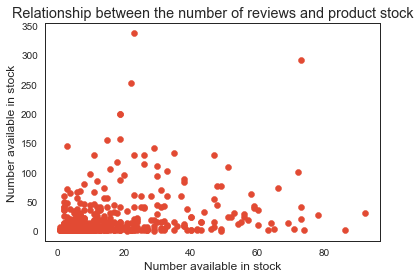

In [48]:
plt.scatter(dframe["number_available_in_stock"], dframe["number_of_reviews"]
                 )

#fig.update_layout(title = "<b>Relationship between the number of reviews and product stock</b>",
#                 plot_bgcolor = "white",
#                 yaxis_title = "Number of reviews",
#                 xaxis_title = "Number available in stock")
plt.title("Relationship between the number of reviews and product stock")
plt.xlabel("Number available in stock")
plt.ylabel("Number available in stock")
plt.show()


relationship from the stock and the number of reviews shows that for lesser stock there are more reviews

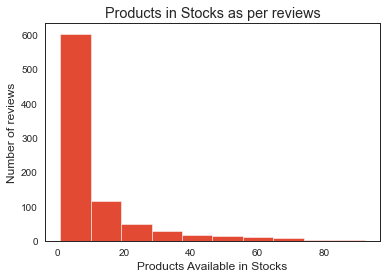

In [49]:
plt.hist(dframe["number_available_in_stock"])
#fig.update_layout(
 #                plot_bgcolor = "#ECECEC",
 #                 xaxis_title = "Products Available in Stocks",
 #                 title = "<b> Products in Stocks</b>"
 #                )
plt.title("Products in Stocks as per reviews")
plt.xlabel("Products Available in Stocks")
plt.ylabel("Number of reviews")
plt.show()

There are 227 products available in 2-3 stocks with highest

Importing data into csv with encoding 'utf-8

In [50]:
dframe.to_csv("Amazon_2022", sep='\t', encoding='utf-8')

Database: Amazon_2022

collection: Review_ml

In [51]:
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri=mongodb://127.0.0.1/Amazon_2022.Review_ml") \
    .config("spark.mongodb.output.uri=mongodb://127.0.0.1/Amazon_2022.Review_ml") \
    .config('spark.driver.extraClassPath', working_directory) \
    .getOrCreate()

In [52]:
data = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").option("Database", "Amazon_2022").option("Collection", "Review_ml").load()

In [53]:
# Schema
data.printSchema()

root
 |-- _id: string (nullable = true)
 |-- average_review_rating(out of 5): string (nullable = true)
 |-- customer_questions_and_answers: string (nullable = true)
 |-- description: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- items_customers_buy_after_viewing_this_item: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- number_available_in_stock: string (nullable = true)
 |-- number_of_answered_questions: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- price_new: string (nullable = true)
 |-- product_description: string (nullable = true)
 |-- product_information: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- sub_category_1: string (nullable = true)
 |-- sub_category_2: string (nullable = true)
 |-- sub_category_3: string (nullable = true)
 |-- uniq_id: string (nullable = true)



In [54]:
# converting the type to float
data = data.withColumn("average_review_rating(out of 5)", data["average_review_rating(out of 5)"].cast('float'))

In [55]:
# Column renaming
data = data.withColumnRenamed("average_review_rating(out of 5)", "review_rating")

In [56]:
data.printSchema()

root
 |-- _id: string (nullable = true)
 |-- review_rating: float (nullable = true)
 |-- customer_questions_and_answers: string (nullable = true)
 |-- description: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- items_customers_buy_after_viewing_this_item: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- number_available_in_stock: string (nullable = true)
 |-- number_of_answered_questions: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- price_new: string (nullable = true)
 |-- product_description: string (nullable = true)
 |-- product_information: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- sub_category_1: string (nullable = true)
 |-- sub_category_2: string (nullable = true)
 |-- sub_category_3: string (nullable = true)
 |-- uniq_id: string (nullable = true)



In [57]:
# Filling the missing data with minimum
data = data.fillna({'review_rating':'2.3'})

In [58]:
data = data.fillna({'customer_questions_and_answers':'unknown'})

In [59]:
qframe = data.select('customer_questions_and_answers','review_rating')

In [60]:
qframe.show()

+------------------------------+-------------+
|customer_questions_and_answers|review_rating|
+------------------------------+-------------+
|                       unknown|          4.8|
|                       unknown|          5.0|
|                       unknown|          5.0|
|                       unknown|          5.0|
|                       unknown|          4.5|
|                       unknown|          4.0|
|                       unknown|          5.0|
|                       unknown|          5.0|
|                       unknown|          4.0|
|                       unknown|          4.8|
|                       unknown|          4.4|
|                       unknown|          5.0|
|                       unknown|          5.0|
|                       unknown|          4.7|
|                       unknown|          5.0|
|                       unknown|          4.5|
|                       unknown|          5.0|
|                       unknown|          5.0|
|            

In [61]:
pdf = qframe.toPandas()
pdf.customer_questions_and_answers.unique()

array(['unknown',
       "Is the item boxed on arrival // The model is mounted on a hard plastic plinth and the plinth is covered by a hard plastic case, around this is a 'window' cardboard sleeve | Is the item bowled on arrval // Yes",
       "Does this tram have motor // No.  It's a small, static model.",
       'can you confirm that i will receive the calendar in the picture (2013) edition? // This is the one I received but I did get mine quite a while ago lol',
       "what other figures can I buy to go with this set? // You could buy clone troopers, chewbacca, any jedi's, really anything you would like. Many thanks shawn | do this this come in the original box in separate packs? // If I understand the question correctly, there were two bags inside the box, one containing the very small pieces.",
       "Product description doesn't match images - Can you confirm that this order is for the product shown in the images with the interiors lego? // It is what I ordered advent calendar i

## Modeling:

In [62]:

qamsg = qframe.filter(qframe.review_rating != "3").select('review_rating','customer_questions_and_answers')
qamsg = qamsg.withColumn("review_rating", qamsg["review_rating"].cast(DoubleType()))

#Converting score to a binary positive - 1 and negative - 0 feature
def toBinary(score):
    if score >= 3: return 1
    else: return 0
udfScoretoBinary=udf(toBinary, StringType())

qamsg = qamsg.withColumn("Target", udfScoretoBinary("review_rating")).select('customer_questions_and_answers','Target')
qamsg.show(2)
def lowcase_text(line):
    return line.lower()
udflowcase_text=udf(lowcase_text, StringType())
text_lowercase = qamsg.withColumn("lowcase_text", udflowcase_text("customer_questions_and_answers")).select('lowcase_text','Target')
# Tokenizing
tokenizer = Tokenizer(inputCol="lowcase_text", outputCol="words")
words_df = tokenizer.transform(text_lowercase)
#words_df.show()
# Removing stop words
remover = StopWordsRemover(inputCol="words", outputCol="filteredwords")
words_df1 = remover.transform(words_df).select("Target","filteredwords")
#words_df1.show()
def stem_tokens(tokens):
    return [PorterStemmer().stem(item) for item in tokens]
def stem_text(tokens):
    stems = stem_tokens(tokens)
    return ' '.join(stems)

udfstem_text=udf(stem_text, StringType())
words_df2 = words_df1.withColumn("final_text", udfstem_text("filteredwords")).select('final_text','Target')
#words_df2.show()
words_df2.cache()
#Renaming features for logreg_modeling
az_train = words_df2.selectExpr("final_text as text", "Target as label")
az_train = az_train.withColumn("label", az_train["label"].cast(DoubleType()))
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# az_train the logreg_model
lgreg = pipeline.fit(az_train)
prediction = lgreg.transform(az_train)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# az_train the logreg_model
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01,.001,1,100,200]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator()  ,
                          numFolds=5)
lgreg = crossval.fit(az_train)
lgreg.avgMetrics

+------------------------------+------+
|customer_questions_and_answers|Target|
+------------------------------+------+
|                       unknown|     1|
|                       unknown|     1|
+------------------------------+------+
only showing top 2 rows



[0.6757334026486945,
 0.6739191104694869,
 0.6806803128167345,
 0.6716627832610883,
 0.6716627832610883,
 0.6716627832610883]

Overall, maximum of 68% accuracy is obtained with logistic regression model

In [63]:
adf = data.toPandas()

In [64]:
adf.describe()

,review_rating
count,1058.000000
mean,4.734878
std,0.372015
min,2.300000
25%,4.500000
50%,5.000000
75%,5.000000
max,5.000000


Text(0, 0.5, ' Rating ')

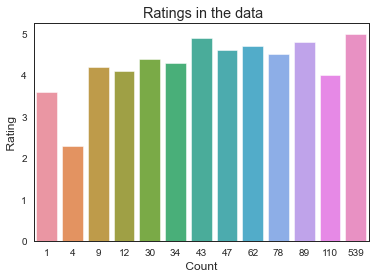

In [65]:
pltrate = adf['review_rating'].value_counts()
sns.barplot(y=pltrate.index,x=pltrate.values)
plt.title(" Ratings in the data")
plt.xlabel(" Count ")
plt.ylabel(" Rating ")

# 

## Electronics Products dataset

Importing dataset of 2018 to analyse the reviews of electronics products.

In [66]:
review_df = pd.read_csv('DatafinitiElectronicsProductData.csv')
review_df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,...,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
2,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,I love the new design the keys are spaced well...,New,Kman,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
3,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,Attached easily and firmly. Has a nice feel. A...,Nice keyboard,UpstateNY,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
4,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"Our original keyboard was okay, but did not ha...",Nice improvement,Glickster,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds


In [67]:
# shape
review_df.shape

(7299, 27)

Correlation of reviews

In [68]:
#Correlation
review_df.corr()

,ean,reviews.numHelpful,reviews.rating,upc
ean,1.000000,-0.040685,0.154502,1.000000
reviews.numHelpful,-0.040685,1.000000,-0.030244,0.020176
reviews.rating,0.154502,-0.030244,1.000000,0.080902
upc,1.000000,0.020176,0.080902,1.000000


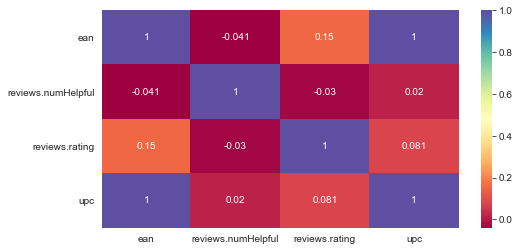

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,4))
sns.heatmap(review_df.corr(),annot=True,cmap='Spectral')
plt.show()

In [70]:
data_new = review_df[['dateAdded','brand','manufacturer','name','primaryCategories']]

In [71]:
data = review_df['reviews.rating'].value_counts()
data

5.0    4492
4.0    1663
3.0     440
1.0     318
2.0     222
Name: reviews.rating, dtype: int64

<AxesSubplot:>

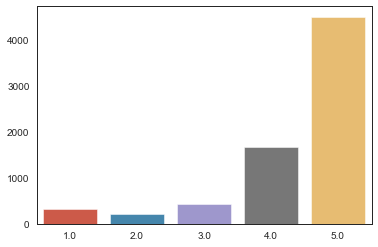

In [72]:
# plot for ratings
sns.barplot(x=data.index, y=data.values)

In [73]:
# dropping the columns which have null values
review_df = review_df.dropna()

Reading Electronics product data from MongoDB

Database: Amazon_2018

collection: reviews

In [74]:
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri=mongodb://127.0.0.1/Amazon_2018.reviews") \
    .config("spark.mongodb.output.uri=mongodb://127.0.0.1/Amazon_2018.reviews") \
    .config('spark.driver.extraClassPath', working_directory) \
    .getOrCreate()
dfa = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").option("Database", "Amazon_2018").option("Collection", "reviews").load()
dfa.show()

+--------------------+----------+---------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+------------+------------------+--------------------+-----------------+--------------------+--------------------+--------+----------+
|                 _id|     asins|    brand|          categories|colors|           dateAdded|         dateUpdated|           dimension|     ean|                  id|           imageURLs|                keys|manufacturer|manufacturerNumber|                name|primaryCategories|             reviews|          sourceURLs|     upc|    weight|
+--------------------+----------+---------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+------------+------------------+--------------------+-----------------+--------------------+--------------------+-

In [75]:
# count 
dfa.count()

7299

In [76]:
# Schema of dfa
dfa.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- colors: string (nullable = true)
 |-- dateAdded: string (nullable = true)
 |-- dateUpdated: string (nullable = true)
 |-- dimension: string (nullable = true)
 |-- ean: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imageURLs: string (nullable = true)
 |-- keys: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- manufacturerNumber: string (nullable = true)
 |-- name: string (nullable = true)
 |-- primaryCategories: string (nullable = true)
 |-- reviews: struct (nullable = true)
 |    |-- date: string (nullable = true)
 |    |-- dateSeen: string (nullable = true)
 |    |-- doRecommend: string (nullable = true)
 |    |-- numHelpful: string (nullable = true)
 |    |-- rating: string (nullable = true)
 |    |-- sourceURLs: string (nullable = true)
 |    

In [77]:
dfb = dfa
dfb.show()

+--------------------+----------+---------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+------------+------------------+--------------------+-----------------+--------------------+--------------------+--------+----------+
|                 _id|     asins|    brand|          categories|colors|           dateAdded|         dateUpdated|           dimension|     ean|                  id|           imageURLs|                keys|manufacturer|manufacturerNumber|                name|primaryCategories|             reviews|          sourceURLs|     upc|    weight|
+--------------------+----------+---------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+------------+------------------+--------------------+-----------------+--------------------+--------------------+-

## Modeling:
 Analysing the data based on rating and assigning positive, negitive and neutral categories

In [78]:
# categorizing the ratings based on the rating into positive, negative or neutral
def condition(r):
    if (r <3):
        label="negative"
    elif(r>3):
        label="positive"
    else:
        label="neutral"
    return label
sentiment_udf = udf(lambda x: condition(x), StringType())

dfc = dfb.withColumn('reviews.text',sentiment_udf(dfb['reviews.rating']))
dfc

DataFrame[_id: struct<oid:string>, asins: string, brand: string, categories: string, colors: string, dateAdded: string, dateUpdated: string, dimension: string, ean: string, id: string, imageURLs: string, keys: string, manufacturer: string, manufacturerNumber: string, name: string, primaryCategories: string, reviews: struct<date:string,dateSeen:string,doRecommend:string,numHelpful:string,rating:string,sourceURLs:string,text:string,title:string,username:string>, sourceURLs: string, upc: string, weight: string, reviews.text: string]

In [79]:
def toBinary(score):
    if score >= 3: return 1
    else: return 0
udfScoretoBinary=udf(toBinary, StringType())

dfc = dfc.withColumn("Target", udfScoretoBinary("reviews.rating"))
dfc

DataFrame[_id: struct<oid:string>, asins: string, brand: string, categories: string, colors: string, dateAdded: string, dateUpdated: string, dimension: string, ean: string, id: string, imageURLs: string, keys: string, manufacturer: string, manufacturerNumber: string, name: string, primaryCategories: string, reviews: struct<date:string,dateSeen:string,doRecommend:string,numHelpful:string,rating:string,sourceURLs:string,text:string,title:string,username:string>, sourceURLs: string, upc: string, weight: string, reviews.text: string, Target: string]

In [80]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SribhanuVeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
pddf = dfa.toPandas()

In [82]:
# Selecting only rating and text columns
sdf = dfa.select('reviews.rating','reviews.text')

In [83]:
sdf.show()

+------+--------------------+
|rating|                text|
+------+--------------------+
|     5|This keyboard is ...|
|     4|It's thin and lig...|
|     4|I love the new de...|
|     5|Attached easily a...|
|     5|Our original keyb...|
|     5|purchased to repl...|
|     4|I find it very co...|
|     3|Good Keyboard and...|
|     4|tough getting it ...|
|     5|I can now quickly...|
|     5|A must have acces...|
|     4|Fingerprint scann...|
|     4|The keyboard feel...|
|     4|I really like the...|
|     4|Good product but ...|
|     5|Best keyboard. A ...|
|     5|Keyboard works pe...|
|     5|Coming from mecha...|
|     4|Keyboard is solid...|
|     5|I did not get the...|
+------+--------------------+
only showing top 20 rows



In [84]:
# Dropping the null value columns
ssdf = sdf.toPandas()
dfr = ssdf.dropna()


In [85]:
ssdf.head()

,rating,text
0,5,"This keyboard is very easy to type on, but the..."
1,4,It's thin and light. I can type pretty easily ...
2,4,I love the new design the keys are spaced well...
3,5,Attached easily and firmly. Has a nice feel. A...
4,5,"Our original keyboard was okay, but did not ha..."


In [86]:
dfr.head()

,rating,text
0,5,"This keyboard is very easy to type on, but the..."
1,4,It's thin and light. I can type pretty easily ...
2,4,I love the new design the keys are spaced well...
3,5,Attached easily and firmly. Has a nice feel. A...
4,5,"Our original keyboard was okay, but did not ha..."


In [87]:
# dropping null values
sdf = sdf.dropna()

In [88]:
sdf.show()

+------+--------------------+
|rating|                text|
+------+--------------------+
|     5|This keyboard is ...|
|     4|It's thin and lig...|
|     4|I love the new de...|
|     5|Attached easily a...|
|     5|Our original keyb...|
|     5|purchased to repl...|
|     4|I find it very co...|
|     3|Good Keyboard and...|
|     4|tough getting it ...|
|     5|I can now quickly...|
|     5|A must have acces...|
|     4|Fingerprint scann...|
|     4|The keyboard feel...|
|     4|I really like the...|
|     4|Good product but ...|
|     5|Best keyboard. A ...|
|     5|Keyboard works pe...|
|     5|Coming from mecha...|
|     4|Keyboard is solid...|
|     5|I did not get the...|
+------+--------------------+
only showing top 20 rows



In [89]:
#datatypes
sdf.dtypes

[('rating', 'string'), ('text', 'string')]

Analysing with vader sentiment analysis and assignig polarity to the data

In [90]:
# Sentiment classification
rdf = sdf.toPandas()
sentiments = pd.DataFrame(list(rdf.text.apply(lambda x: vaderSentiment.SentimentIntensityAnalyzer().polarity_scores(x))))

In [91]:
sentiments

,neg,neu,pos,compound
0,0.000,0.727,0.273,0.8358
1,0.000,0.616,0.384,0.6808
2,0.060,0.686,0.253,0.7925
3,0.000,0.698,0.302,0.6369
4,0.000,0.853,0.147,0.4588
...,...,...,...,...
7125,0.034,0.741,0.225,0.9836
7126,0.000,0.654,0.346,0.6478
7127,0.000,0.490,0.510,0.8070
7128,0.000,0.833,0.167,0.7778


Analysing and visualizing based on positive and negative sentiments average values

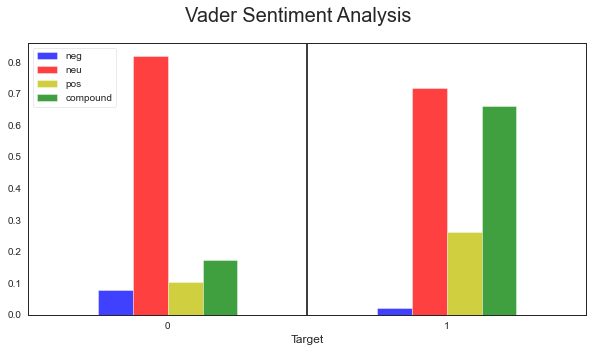

In [92]:
#Ratings processing
sentiments['Target'] = list(rdf['rating'])
sentiments = sentiments.loc[sentiments.Target != 3,]
sentiments['Target'] = sentiments['Target'].astype('int')
sentiments.Target = sentiments.Target.apply(lambda x: 1 if x>3 else 0)

# Plotting the postive and negative sentiments average values from Vader Sentiment library
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sentiments.groupby('Target').mean().plot(kind='bar',alpha=0.75, rot=0,color = ['b','r','y','g']);
plt.suptitle('Vader Sentiment Analysis', fontsize=20)
plt.axvline(0.5, color='black');

Data after assigning of polarity

In [93]:
sentiments

,neg,neu,pos,compound,Target
0,0.000,0.727,0.273,0.8358,1
1,0.000,0.616,0.384,0.6808,1
2,0.060,0.686,0.253,0.7925,1
3,0.000,0.698,0.302,0.6369,1
4,0.000,0.853,0.147,0.4588,1
...,...,...,...,...,...
7125,0.034,0.741,0.225,0.9836,1
7126,0.000,0.654,0.346,0.6478,1
7127,0.000,0.490,0.510,0.8070,1
7128,0.000,0.833,0.167,0.7778,1


Filtering the data based on reviews and ratings

In [94]:
stemmer = PorterStemmer()

In [95]:
textmsg = sdf.filter(sdf.rating != "3").select('rating','text')
textmsg = textmsg.withColumn("rating", textmsg["rating"].cast(DoubleType()))

#Converting score to a binary positive - 1 and negative - 0 feature
def toBinary(score):
    if score >= 3: return 1
    else: return 0
udfScoretoBinary=udf(toBinary, StringType())

textmsg = textmsg.withColumn("Target", udfScoretoBinary("rating")).select('text','Target')
textmsg.show(2)

+--------------------+------+
|                text|Target|
+--------------------+------+
|This keyboard is ...|     1|
|It's thin and lig...|     1|
+--------------------+------+
only showing top 2 rows



In [96]:
textmsg.dtypes

[('text', 'string'), ('Target', 'string')]

Converting into lower case letters

In [97]:
def lower_text(line):
    return line.lower()
udflower_text=udf(lower_text, StringType())
text_lowercase = textmsg.withColumn("lower_text", udflower_text("text")).select('lower_text','Target')

Tokenizing the lower case text into words

In [98]:
# Tokenizing
tokenizer = Tokenizer(inputCol="lower_text", outputCol="words")
wordsDataFrame = tokenizer.transform(text_lowercase)
wordsDataFrame.show()

+--------------------+------+--------------------+
|          lower_text|Target|               words|
+--------------------+------+--------------------+
|this keyboard is ...|     1|[this, keyboard, ...|
|it's thin and lig...|     1|[it's, thin, and,...|
|i love the new de...|     1|[i, love, the, ne...|
|attached easily a...|     1|[attached, easily...|
|our original keyb...|     1|[our, original, k...|
|purchased to repl...|     1|[purchased, to, r...|
|i find it very co...|     1|[i, find, it, ver...|
|tough getting it ...|     1|[tough, getting, ...|
|i can now quickly...|     1|[i, can, now, qui...|
|a must have acces...|     1|[a, must, have, a...|
|fingerprint scann...|     1|[fingerprint, sca...|
|the keyboard feel...|     1|[the, keyboard, f...|
|i really like the...|     1|[i, really, like,...|
|good product but ...|     1|[good, product, b...|
|best keyboard. a ...|     1|[best, keyboard.,...|
|keyboard works pe...|     1|[keyboard, works,...|
|coming from mecha...|     1|[c

Removing the stop words and filtering the words from uncessary words

In [99]:
# Removing stop words
remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
wordsDataFrame1 = remover.transform(wordsDataFrame).select("Target","words_filtered")
wordsDataFrame1.show()

+------+--------------------+
|Target|      words_filtered|
+------+--------------------+
|     1|[keyboard, easy, ...|
|     1|[thin, light., ty...|
|     1|[love, new, desig...|
|     1|[attached, easily...|
|     1|[original, keyboa...|
|     1|[purchased, repla...|
|     1|[find, comfortabl...|
|     1|[tough, getting, ...|
|     1|[quickly, hassle,...|
|     1|[must, accessory,...|
|     1|[fingerprint, sca...|
|     1|[keyboard, feels,...|
|     1|[really, like, fi...|
|     1|[good, product, e...|
|     1|[best, keyboard.,...|
|     1|[keyboard, works,...|
|     1|[coming, mechanic...|
|     1|[keyboard, solid,...|
|     1|[get, surface, pr...|
|     1|[good, keyboard.,...|
+------+--------------------+
only showing top 20 rows



Joining the tokens for final prediction

In [100]:
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
def stem_text(tokens):
    stems = stem_tokens(tokens)
    return ' '.join(stems)

udfstem_text=udf(stem_text, StringType())
wordsDataFrame2 = wordsDataFrame1.withColumn("final_text", udfstem_text("words_filtered")).select('final_text','Target')
wordsDataFrame2.show()

+--------------------+------+
|          final_text|Target|
+--------------------+------+
|keyboard easi typ...|     1|
|thin light. type ...|     1|
|love new design k...|     1|
|attach easili fir...|     1|
|origin keyboard o...|     1|
|purchas replac or...|     1|
|find comfort type...|     1|
|tough get work su...|     1|
|quickli hassl fre...|     1|
|must accessori su...|     1|
|fingerprint scann...|     1|
|keyboard feel sur...|     1|
|realli like finge...|     1|
|good product expe...|     1|
|best keyboard. mu...|     1|
|keyboard work per...|     1|
|come mechan switc...|     1|
|keyboard solid wo...|     1|
|get surfac pro 4 ...|     1|
|good keyboard. li...|     1|
+--------------------+------+
only showing top 20 rows



## Modeling

From training data, initially tokenizing, hashing, performing idf and logistic regression model 

In [101]:
wordsDataFrame2.cache()
#Renaming features for logreg_modeling
sdf_train = wordsDataFrame2.selectExpr("final_text as text", "Target as label")
sdf_train = sdf_train.withColumn("label", sdf_train["label"].cast(DoubleType()))
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# sdf_train the logreg_model
logred_model = pipeline.fit(sdf_train)

Predicting the model and cross validating the model with final results

In [102]:
prediction = logred_model.transform(sdf_train)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# sdf_train the logreg_model
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01,.001,1,100,200]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator()  ,
                          numFolds=5)
logred_model = crossval.fit(sdf_train)
logred_model.avgMetrics

[0.8750559819610355,
 0.8535765898145584,
 0.8508940767256269,
 0.8921169691242505,
 0.8448428853346371,
 0.843305381567491]

Overall, the maximum accuracy metric for the model so far found to be 89% for electronics products wiith logistic regression.

## References: 

https://github.com/aayushmnit/big-data-project/blob/master/PySpark-Text%20Analytics%20on%20Amazon%20Reviews%20-%20Draft1.ipynb

https://data.world/datafiniti/amazon-and-best-buy-electronics

https://www.kaggle.com/datasets/nguyenngocphung/10000-amazon-products-dataset

https://sparkbyexamples.com/

https://stackoverflow.com/questions/50963444/failed-to-find-data-source-com-mongodb-spark-sql-defaultsource